In [2]:
from formulas import *
import math
from sklearn import preprocessing, svm #scale, regresions, cross shuffle stats sepeareate data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import load_iris 
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
df = yf.Ticker('TSLA').history(period="max").reset_index()
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...,...
3357,2023-10-30 00:00:00-04:00,209.279999,210.880005,194.669998,197.360001,136448200,0.0,0.0
3358,2023-10-31 00:00:00-04:00,196.119995,202.800003,194.070007,200.839996,118068300,0.0,0.0
3359,2023-11-01 00:00:00-04:00,204.039993,205.990005,197.850006,205.660004,121661700,0.0,0.0
3360,2023-11-02 00:00:00-04:00,212.970001,219.199997,211.449997,218.509995,125987600,0.0,0.0


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

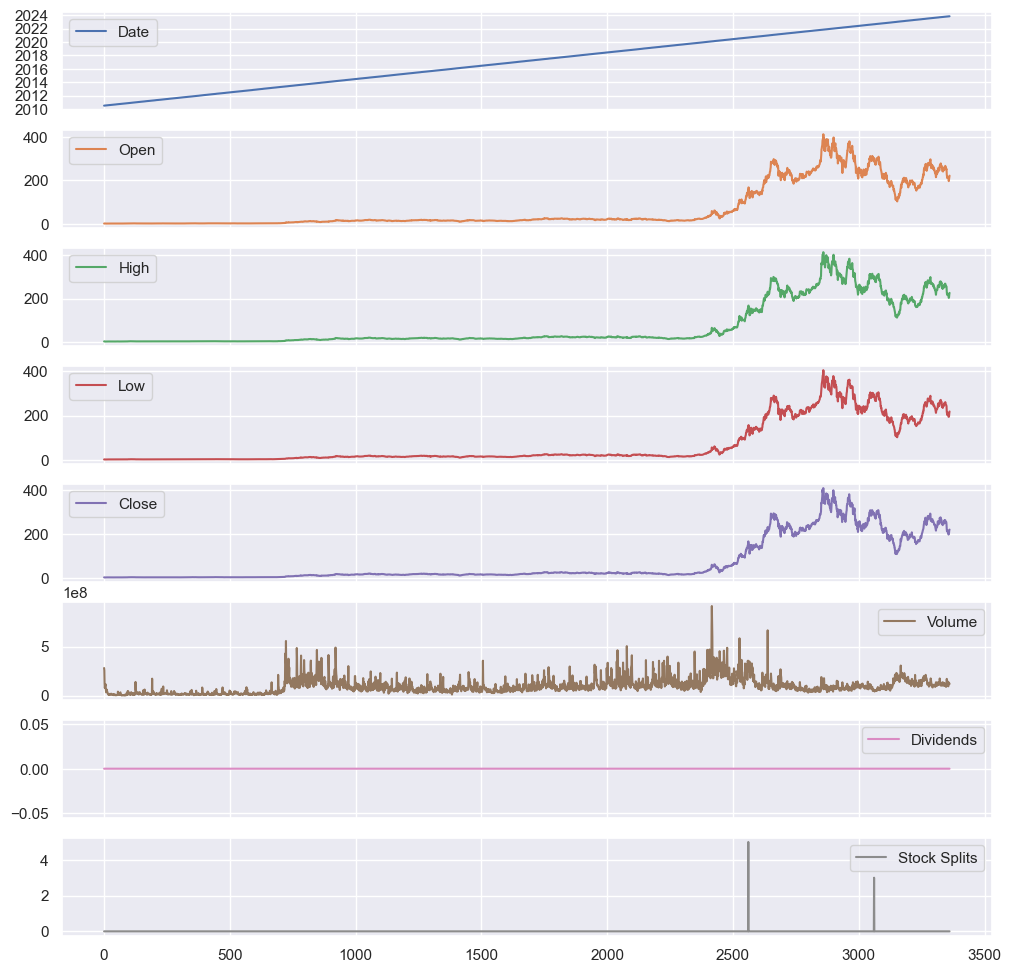

In [4]:
df.plot(kind="line",figsize=(12,12),subplots=True)

In [5]:
df.shape

(3362, 8)

In [6]:
series = df['Close']

# Create train data set
train_split_date = '2019-12-31'
train_split_index = np.where(df.Date == train_split_date)[0][0]
x_train = df.loc[df['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2021-12-01'
test_split_index = np.where(df.Date == test_split_date)[0][0]
x_test = df.loc[df['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = df.loc[(df['Date'] < test_split_date) & (df['Date'] > train_split_date)]['Close']

2393 2394 2876 2877 3361


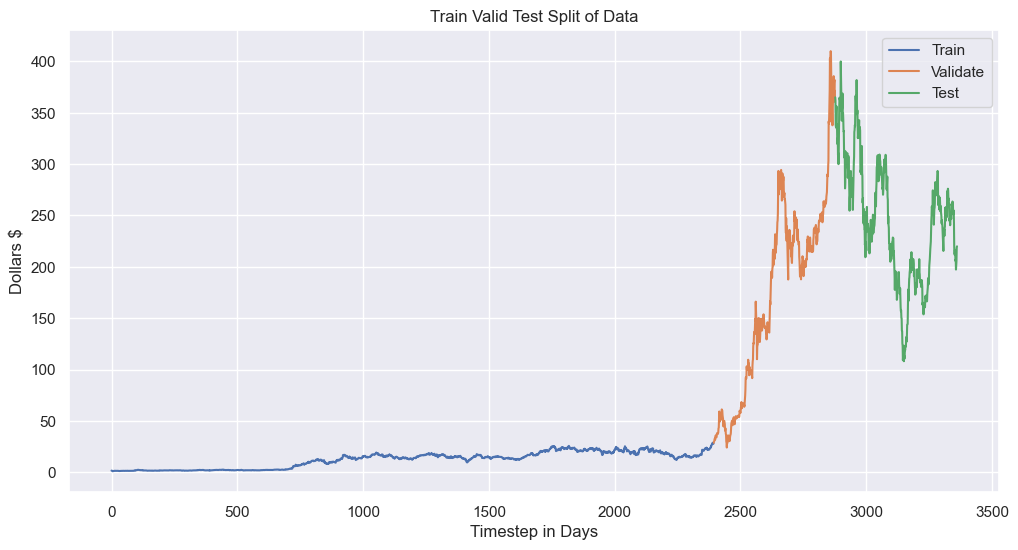

In [7]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [19]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}
model_rmse_scores = {}

# Base Model - Naive Forecasting
A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.

In [20]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

Text(0.5, 1.0, 'Price History of TSLA June-2010 to Sept-2023')

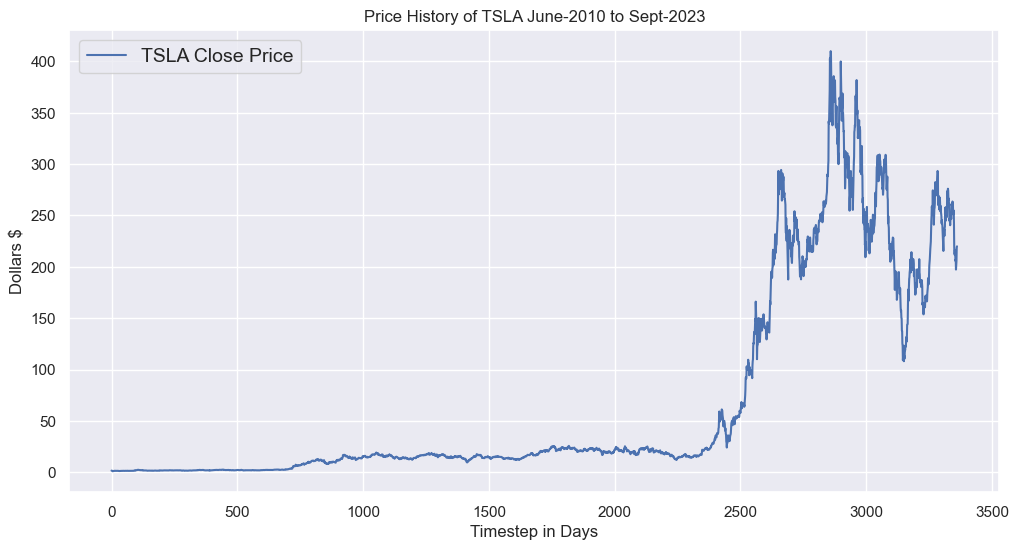

In [21]:
# Plot chart with all details untouched
plot_series(time=df.index, series= df['Close'], label='TSLA Close Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Price History of TSLA June-2010 to Sept-2023')

In [22]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Naive Forecast vs Actual')

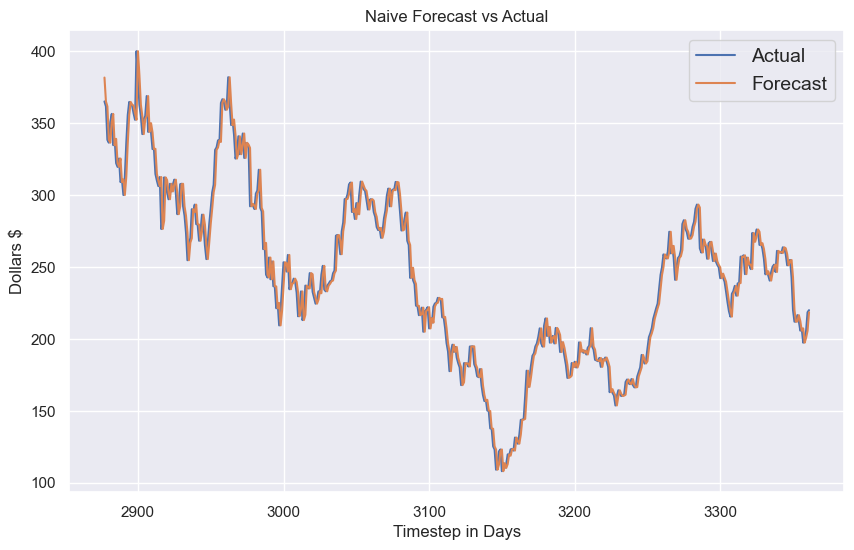

In [23]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Naive Forecast vs Actual')

In [28]:
# Calculate RMSE
naive_forecast_rmse = np.sqrt(mean_squared_error(x_test,naive_forecast))
print(f"Root Mean Square Error (RMSE): {naive_forecast_rmse}")

Root Mean Square Error (RMSE): 9.757624968423897


In [27]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy()
model_mae_scores['Naive'] = naive_forecast_mae
model_rmse_scores['Naive'] = naive_forecast_rmse
# view the dictionary of mae scores
model_mae_scores,model_rmse_scores

({'Naive': 7.184151781219797}, {'Naive': 9.757624968423897})

In [29]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[381.58666992 365.         361.5333252 ]
[365.         361.5333252  338.32333374]
****************************************************************************************************
[16.58666992  3.4666748  23.20999146]


Text(0.5, 1.0, 'SMA20 vs Actual')

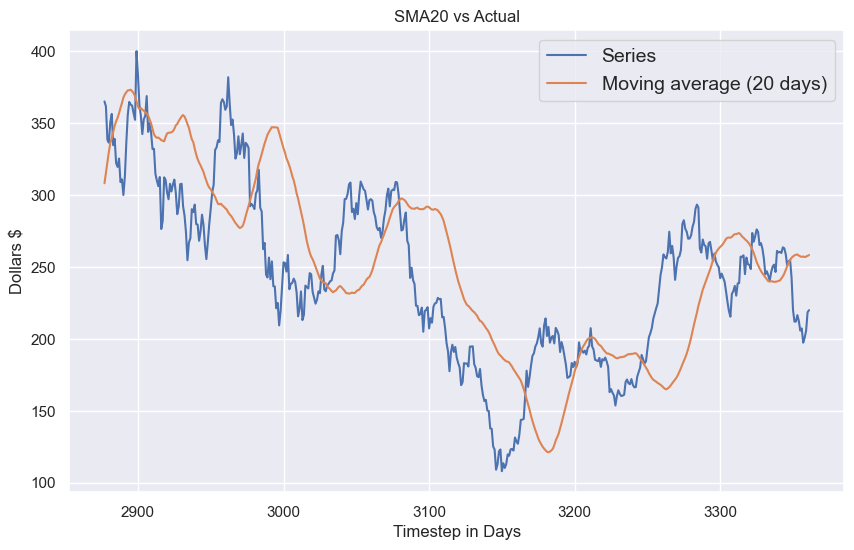

In [30]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = df['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:df.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')

In [32]:
ma_20 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()
ma20_rmse=np.sqrt(mean_squared_error(x_test,moving_avg_forecast))

model_mae_scores['SMA 20'] = ma_20
model_rmse_scores['SMA 20'] = ma20_rmse
model_mae_scores, model_rmse_scores

({'Naive': 7.184151781219797, 'SMA 20': 41.671825369608776},
 {'Naive': 9.757624968423897, 'SMA 20': 50.38672843916514})

# Weekly Moving Average (5 day MA)
I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

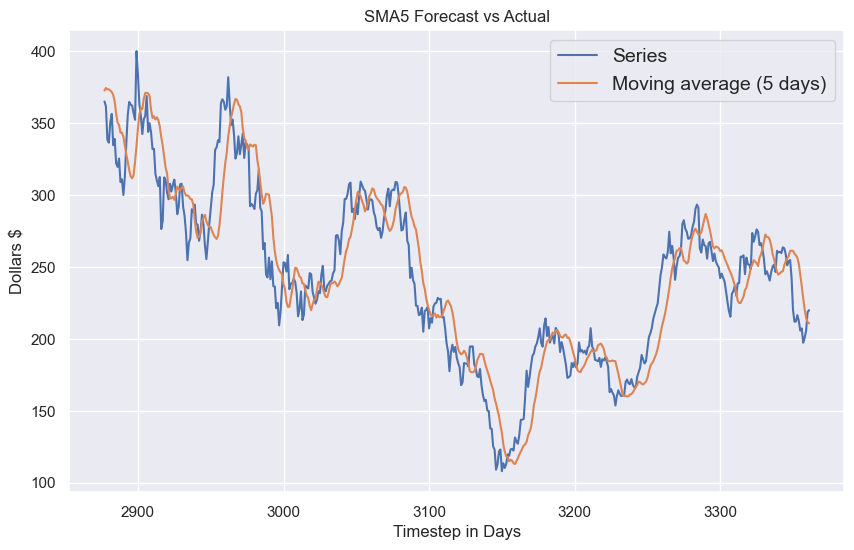

In [33]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = df['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:df.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [34]:
# Calculate MAE
ma_5 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()
ma5_rmse=np.sqrt(mean_squared_error(x_test,moving_avg_forecast))

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_rmse_scores['SMA 5'] = ma5_rmse
model_mae_scores, model_rmse_scores

({'Naive': 7.184151781219797,
  'SMA 20': 41.671825369608776,
  'SMA 5': 19.317487446893125},
 {'Naive': 9.757624968423897,
  'SMA 20': 50.38672843916514,
  'SMA 5': 24.056122615287617})

# ARIMA

### Step 1: Is the data stationary?

Use Augmented Dickey Fuller test to determine if the data is stationary
- Failure to reject the null hypothesis means the data is not stationary

In [35]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

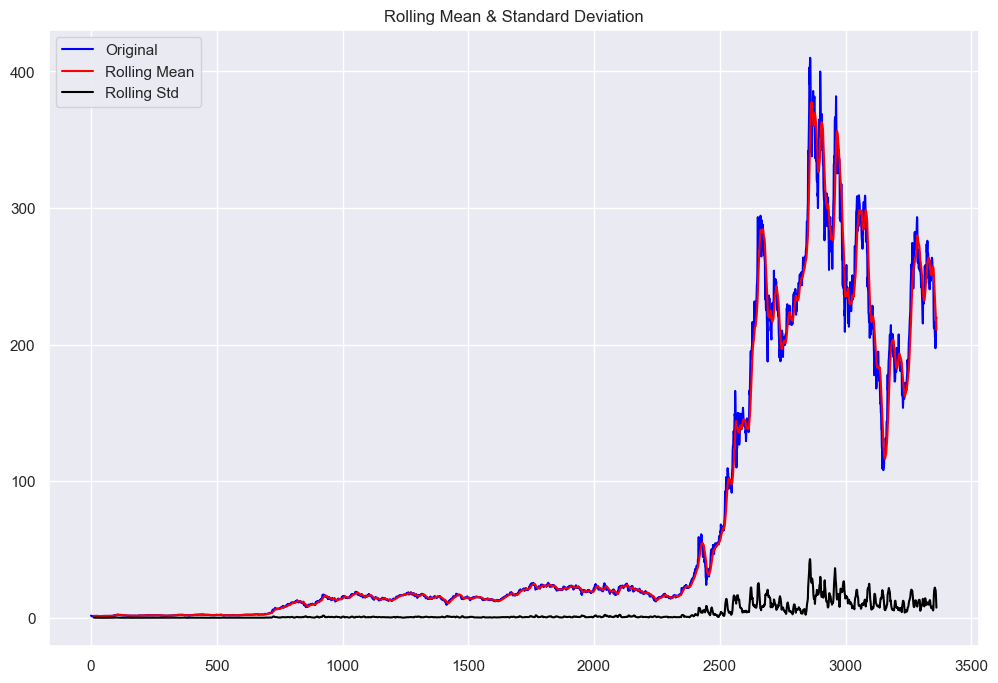

Results of Dickey-Fuller Test:
p-value = 0.6882. The series is likely non-stationary.
Test Statistic                   -1.165630
p-value                           0.688204
#Lags Used                       18.000000
Number of Observations Used    3343.000000
Critical Value (1%)              -3.432308
Critical Value (5%)              -2.862405
Critical Value (10%)             -2.567230
dtype: float64


In [36]:
test_stationarity(series)

The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not statio

### Step 2 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [37]:
# Get the difference of each Adj Close point
tsla_close_diff_1 = series.diff()
tsla_close_diff_1.dropna(inplace=True)

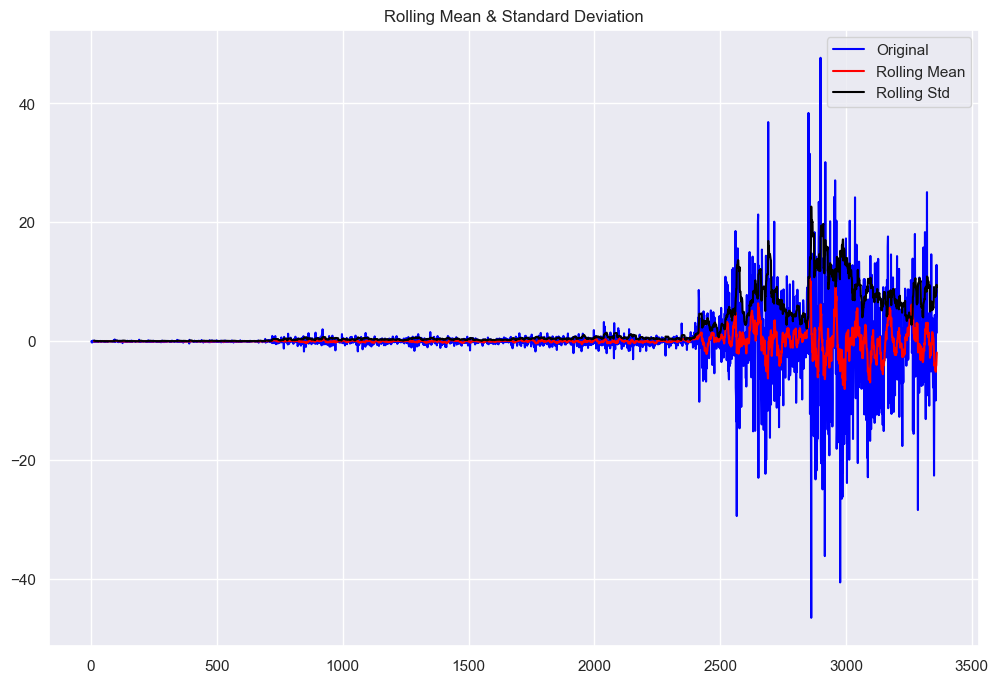

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.287477e+01
p-value                        4.795210e-24
#Lags Used                     1.700000e+01
Number of Observations Used    3.343000e+03
Critical Value (1%)           -3.432308e+00
Critical Value (5%)           -2.862405e+00
Critical Value (10%)          -2.567230e+00
dtype: float64


In [38]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(tsla_close_diff_1)

The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

### Step 3: Autocorrelation and Partial autocorrelation

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

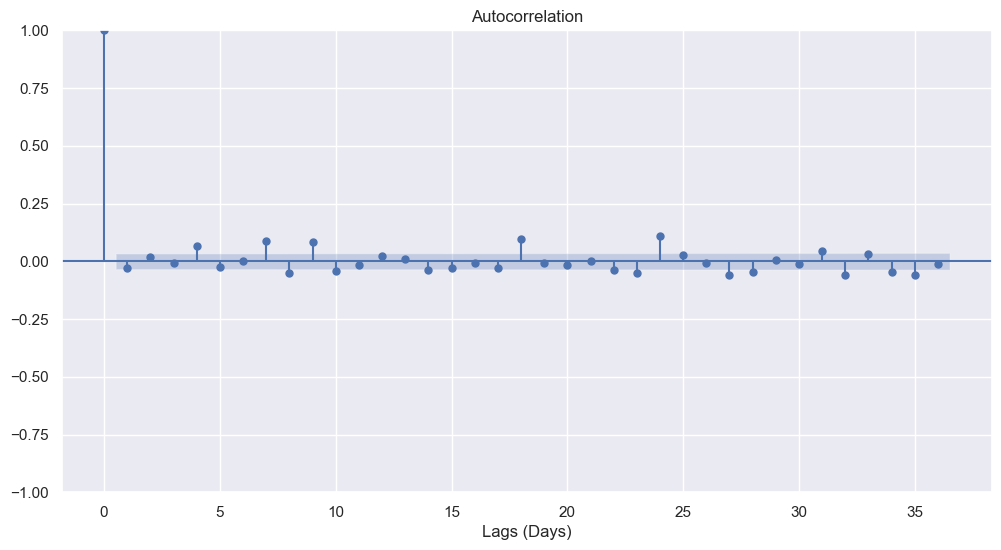

In [39]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(tsla_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

C:\Users\satvi\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


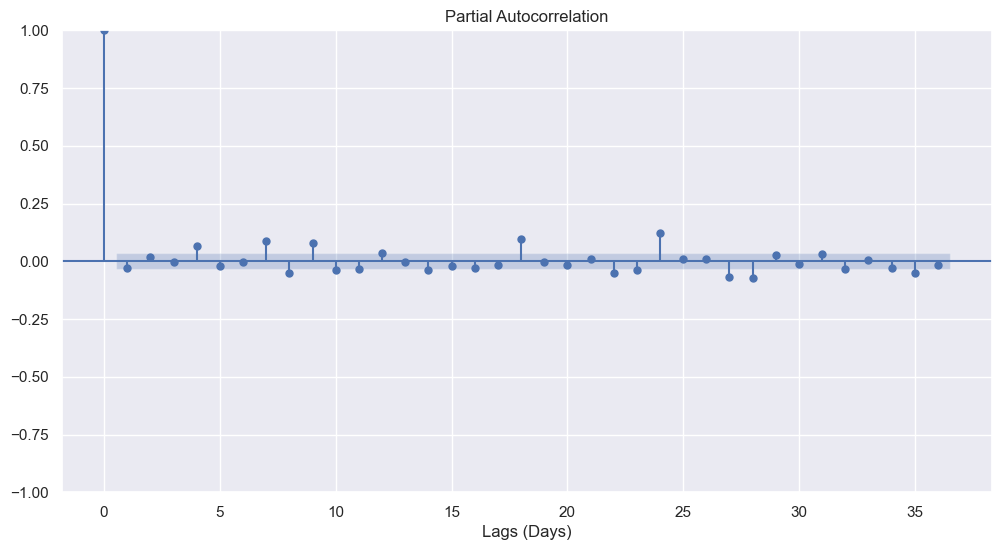

In [40]:
plot_pacf(tsla_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

- These plots look almost identical, but they’re not. Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, and the 2nd lag is positive, we will use the 1st lag as a moving average point.
<br/><br/>
- For the PACF plot, since there is a substantial dropoff at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.
<br/><br/>
- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term. We have determined the best model for our data is of order (1,1,1). Once again, feel free to change these numbers and print out the summary of the models to see which variation has the lowest AIC. The training time is relatively quick.

### Testing different arima models

In [41]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(x_train, order=(4,2,0))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2394
Model:                 ARIMA(4, 2, 0)   Log Likelihood               -1539.560
Date:                Sun, 05 Nov 2023   AIC                           3089.120
Time:                        22:08:40   BIC                           3118.019
Sample:                             0   HQIC                          3099.635
                               - 2394                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7940      0.012    -68.317      0.000      -0.817      -0.771
ar.L2         -0.5707      0.016    -36.134      0.000      -0.602      -0.540
ar.L3         -0.3802      0.017    -21.869      0.0

NormaltestResult(statistic=393.94877021880006, pvalue=2.851750134494332e-86)
This distribution is not a normal distribution


C:\Users\satvi\AppData\Local\Temp\ipykernel_26020\1130104175.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats
C:\Users\satvi\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


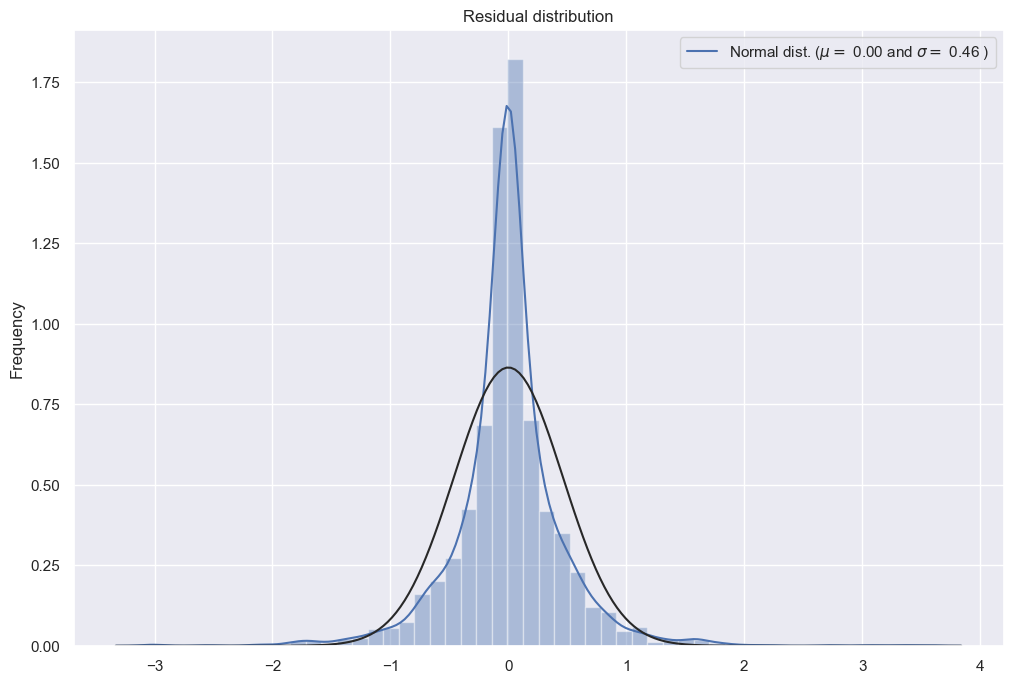

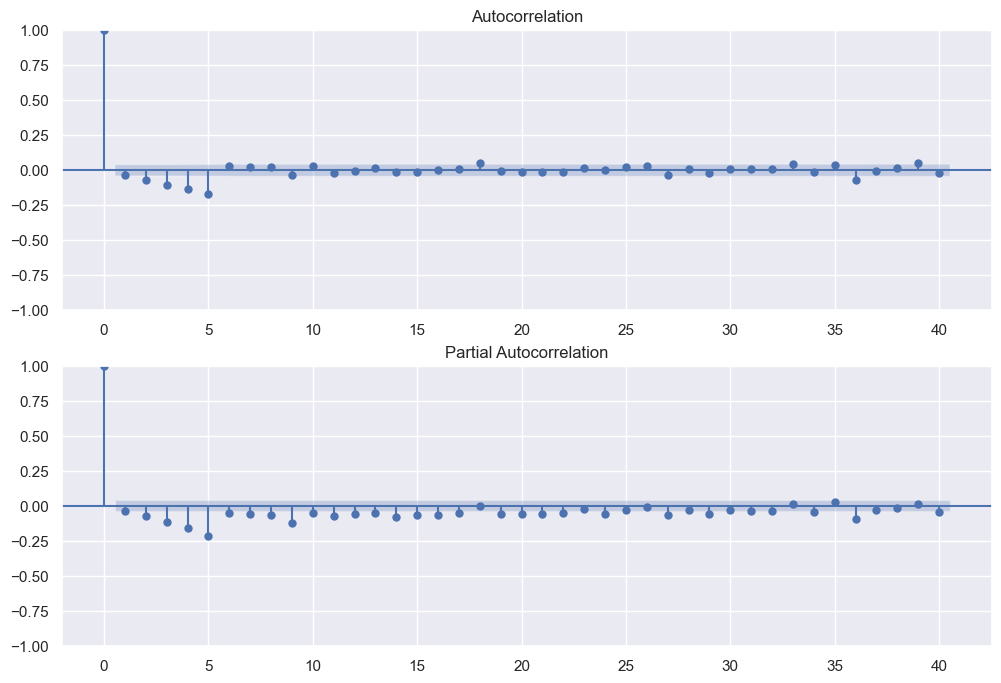

In [42]:
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = result.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

### Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (4,2,0) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

In [44]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index[-766:]):
    model = sm.tsa.arima.ARIMA(history, order=(4,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
        
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 10.339464773562117
Stored 'model_predictions' (list)


In [45]:
output

array([219.95393016])

In [46]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[27.846449547309856,
 529.1183189181179,
 287.3077650895842,
 429.15390589827535,
 528.4934465568261]

In [47]:
model_predictions

[27.846449547309856,
 529.1183189181179,
 287.3077650895842,
 429.15390589827535,
 528.4934465568261,
 667.1830910465986,
 352.44910329669284,
 328.79502647015994,
 341.2688893602513,
 319.47635586098755,
 313.4845361347684,
 318.8092415486513,
 303.0046116494301,
 305.8775232169266,
 295.57157874639097,
 311.34453275134416,
 336.9073721020737,
 363.0711395350332,
 374.7483366163335,
 376.30955222541843,
 373.37862505515267,
 361.6475980337157,
 351.9967303339311,
 406.74183941096516,
 384.40865595831514,
 364.61482808704534,
 357.6708221395351,
 341.2497886721734,
 342.66499938993366,
 347.4305671591145,
 369.19930949465794,
 341.0927052713468,
 353.30326351367415,
 341.76663019343016,
 327.34509760711336,
 324.9330781448891,
 308.84056783774264,
 302.54744552446414,
 298.4824123279388,
 308.08912859466926,
 264.7235542727819,
 277.3346965302165,
 311.50489634582016,
 308.17239412361255,
 299.7230884792151,
 303.1928066013761,
 313.6896848882231,
 299.3914652731456,
 306.7127354989212

In [48]:
#save model
model_fit.save('arima_111.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_111.pkl')

In [50]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
arima_rmse=np.sqrt(mean_squared_error(x_test,model_predictions))

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_rmse_scores['ARIMA'] = arima_rmse
model_mae_scores, model_rmse_scores

({'Naive': 7.184151781219797,
  'SMA 20': 41.671825369608776,
  'SMA 5': 19.317487446893125,
  'ARIMA': 10.339464773562117},
 {'Naive': 9.757624968423897,
  'SMA 20': 50.38672843916514,
  'SMA 5': 24.056122615287617,
  'ARIMA': 26.296264164743157})

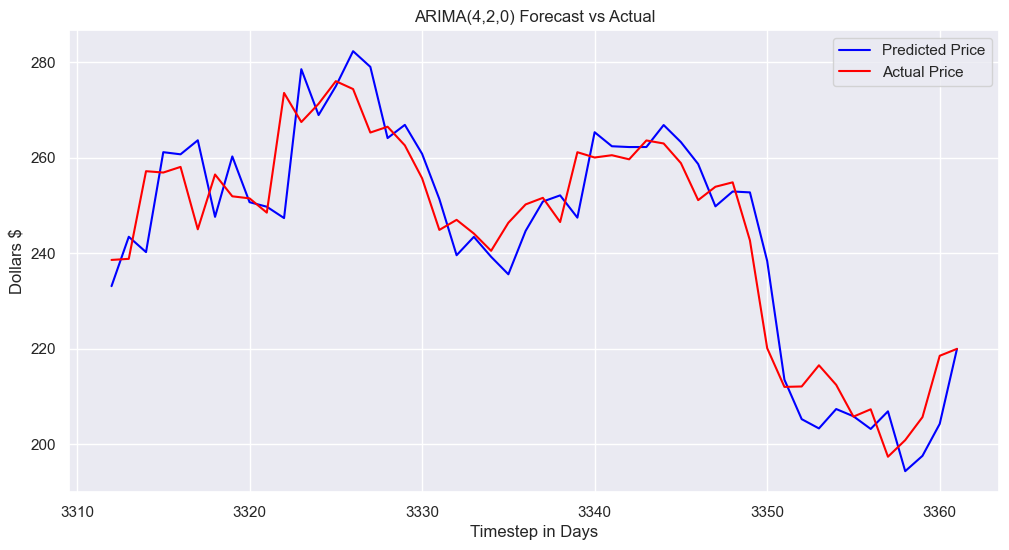

<Figure size 1500x600 with 0 Axes>

In [51]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-50:], model_predictions[-50:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-50:], x_test[-50:], color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(4,2,0) Forecast vs Actual')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(15,6))
plt.show()

## Show Error in model vs actual

In [52]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

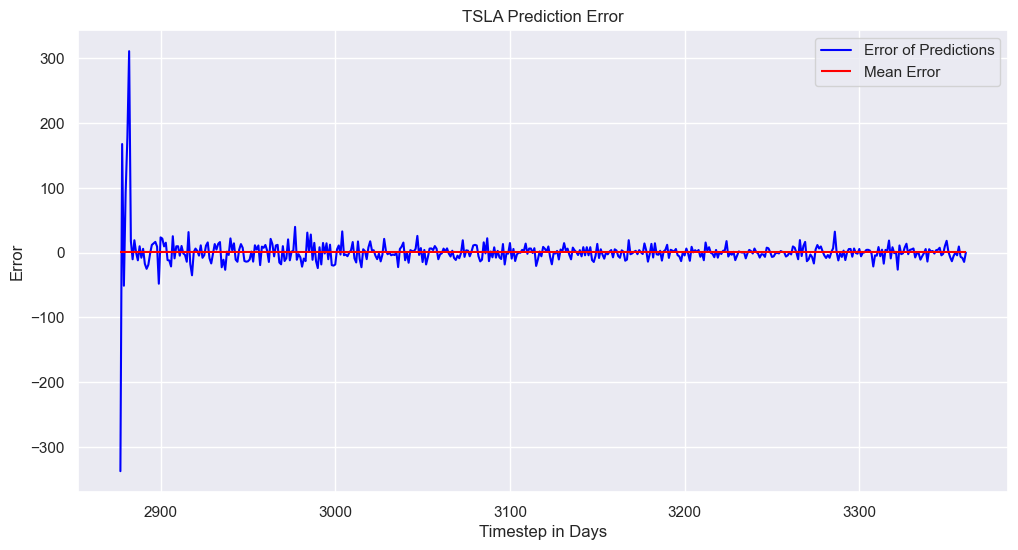

<Figure size 1000x600 with 0 Axes>

In [53]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('TSLA Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

### Streamlit Link1: http://localhost:8501/
### Streamlit Link2: http://192.168.29.179:8501/

# Summary of ALL Model Results
### Bringing in values from other deep learning models

In [54]:
model_mae_scores['Linear Model'] = 37.628902
model_mae_scores['LSTM Model'] = 1.6099837
model_mae_scores['CNN Model'] = 7.652614

In [55]:
# Store MAE scores
%store model_mae_scores

Stored 'model_mae_scores' (dict)


In [56]:
%store -r model_mae_scores
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'Naive': 7.184151781219797,
 'SMA 20': 41.671825369608776,
 'SMA 5': 19.317487446893125,
 'ARIMA': 10.339464773562117,
 'Linear Model': 37.628902,
 'LSTM Model': 1.6099837,
 'CNN Model': 7.652614}

In [57]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

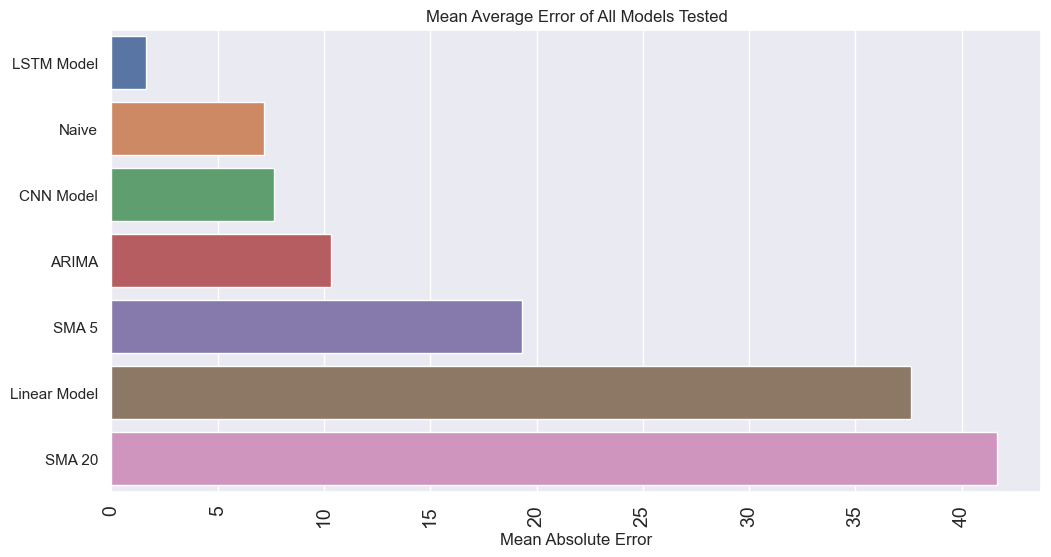

In [58]:
# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Absolute Error of All Models Tested')


In [59]:
model_rmse_scores['Linear Model'] = 45.658056999221174
model_rmse_scores['LSTM Model'] = 2.3732193111447857
model_rmse_scores['CNN Model'] = 10.234576185854324

In [60]:
# Store RMSE scores
%store model_rmse_scores

Stored 'model_rmse_scores' (dict)


In [61]:
%store -r model_rmse_scores
rmse_series = pd.Series(model_rmse_scores)
model_rmse_scores

{'Naive': 9.757624968423897,
 'SMA 20': 50.38672843916514,
 'SMA 5': 24.056122615287617,
 'ARIMA': 26.296264164743157,
 'Linear Model': 45.658056999221174,
 'LSTM Model': 2.3732193111447857,
 'CNN Model': 10.234576185854324}

In [62]:
# Sort vales for clean bar chart
order1 = rmse_series.sort_values()

Text(0.5, 1.0, 'Root Mean Square Error of All Models Tested')

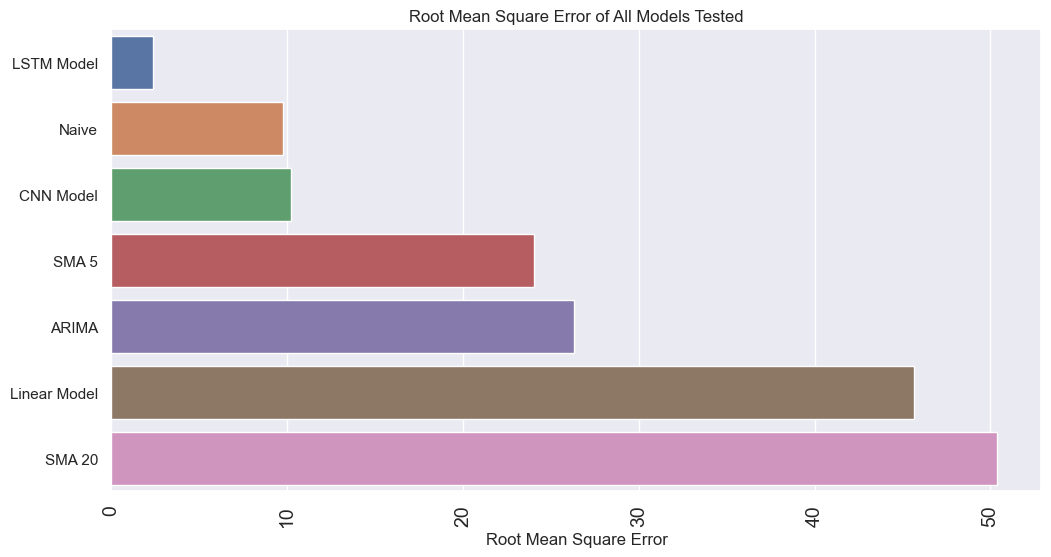

In [63]:
# Create bar chart for to show RMSE of all models side by side
sns.barplot(x=order1.values, y = order1.index, orient='h')
plt.xlabel('Root Mean Square Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Root Mean Square Error of All Models Tested')


In [2]:
model_rmse_scores

NameError: name 'model_rmse_scores' is not defined